# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The Dataset contains data from 17 marketting campaigns. Telephone and human agent as the interlocutorrepresents were 2 prominent campaigns. There were also some campaigns using online banking channels.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

Import the required packages

In [1]:
# install package category_encoders that has JamesSteinEncoder
!pip install category_encoders

In [2]:
import statsmodels.api as sm
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score,roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


As colab is being used for the assignment, mount the drive where the vehicles dataset is being stored

In [3]:
from google.colab import drive
drive.mount('/content/drive')
raw_df = pd.read_csv('/content/drive/MyDrive/classifier_comparison/data/bank-additional-full.csv', sep = ';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# if using a local copy of the data uncomment the following to read the raw dataset
#raw_df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep = ';')

In [5]:
raw_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



Let us look at the null percent of the different columns.

<Figure size 1500x1000 with 0 Axes>

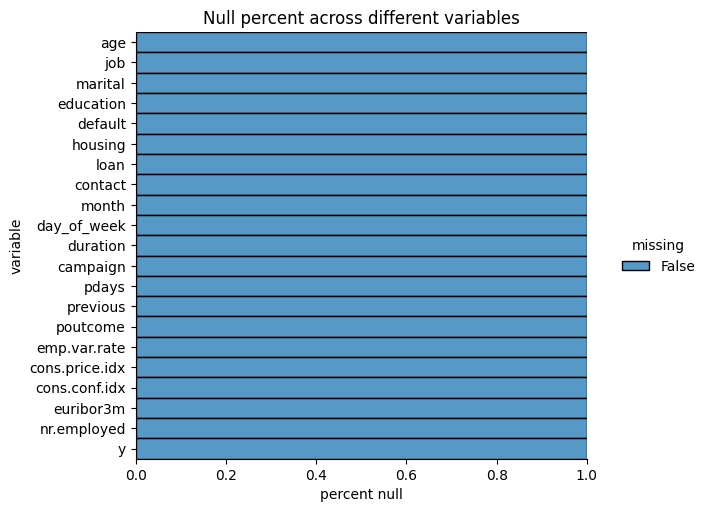

In [6]:
plt.figure(figsize=(15,10))
fig = sns.displot(
    data=raw_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
fig.set(xlabel='percent null', ylabel='variable')
plt.title("Null percent across different variables")
plt.show()

From the above it seems like there arent any columns with missing values. We will also analyze the actual values in the different columns.

Let's force a type conversion for the different columns and look at the different columns types post this action.

In [7]:
raw_df = raw_df.convert_dtypes()
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  Int64  
 1   job             41188 non-null  string 
 2   marital         41188 non-null  string 
 3   education       41188 non-null  string 
 4   default         41188 non-null  string 
 5   housing         41188 non-null  string 
 6   loan            41188 non-null  string 
 7   contact         41188 non-null  string 
 8   month           41188 non-null  string 
 9   day_of_week     41188 non-null  string 
 10  duration        41188 non-null  Int64  
 11  campaign        41188 non-null  Int64  
 12  pdays           41188 non-null  Int64  
 13  previous        41188 non-null  Int64  
 14  poutcome        41188 non-null  string 
 15  emp.var.rate    41188 non-null  Float64
 16  cons.price.idx  41188 non-null  Float64
 17  cons.conf.idx   41188 non-null 

From the above we see that there are several string columns job           ,marital , education , default, housing ,loan,contact  , month , day_of_week and poutcome. Lets look at the different categories of values for these features to understand if these are categorical.

Let's explore the cardinality across different string features.


In [8]:
string_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

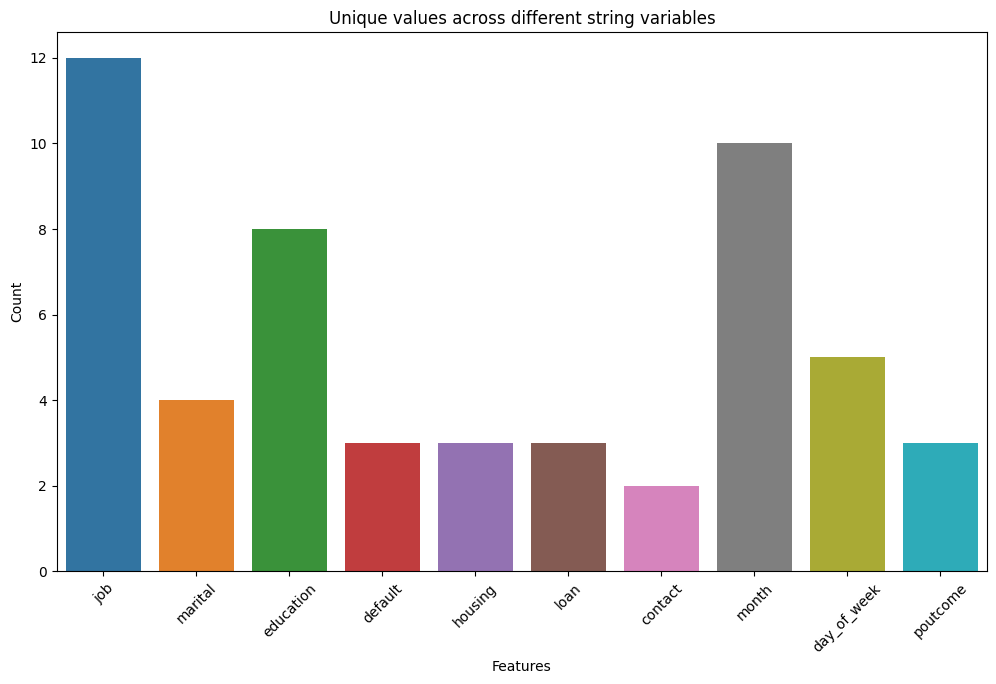

In [9]:
count_df = raw_df[string_features].nunique().reset_index()
count_df.columns = ['feature','unique_values']
count_df
plt.figure(figsize=(12,7))
g = sns.barplot(data=count_df, x='feature', y='unique_values')

g.set_xticklabels(count_df['feature'], rotation=45)
plt.title("Unique values across different string variables")

_ = g.set(xlabel="Features", ylabel="Count")

A few of the categorical features have categories > 4, let us visualize them independently, the lesser category variables we will visualize using subplots.

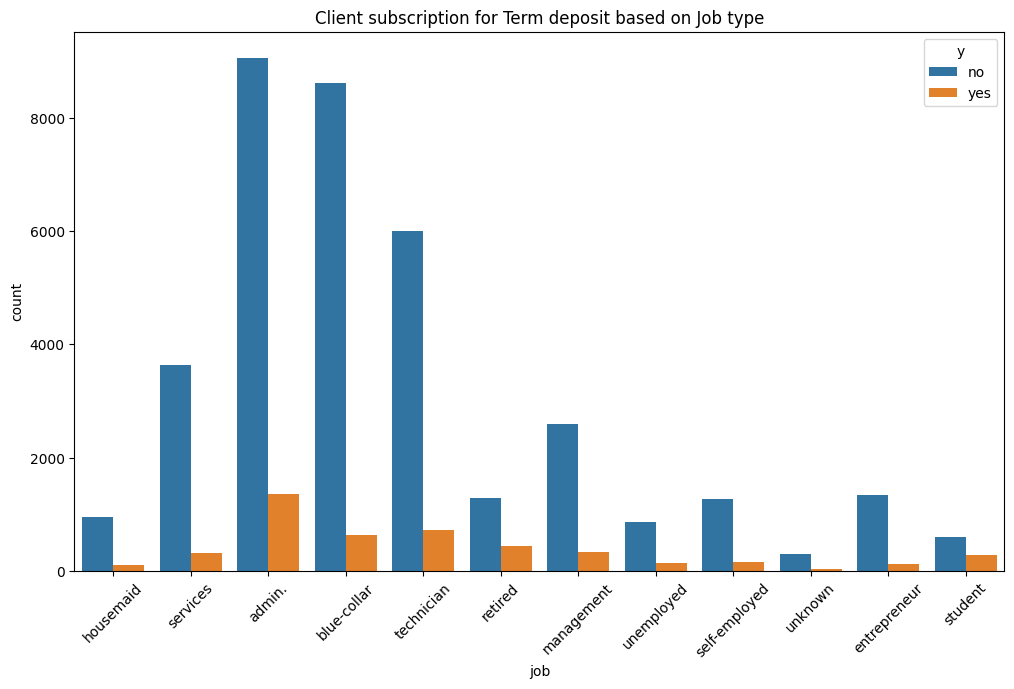

In [10]:
plt.figure(figsize=(12,7))
sns.countplot(raw_df, x="job", hue="y")
plt.xticks(rotation=45)
plt.title("Client subscription for Term deposit based on Job type")

_ = g.set(xlabel="Features", ylabel="Count")

Ploting Client subscriptions based on Education

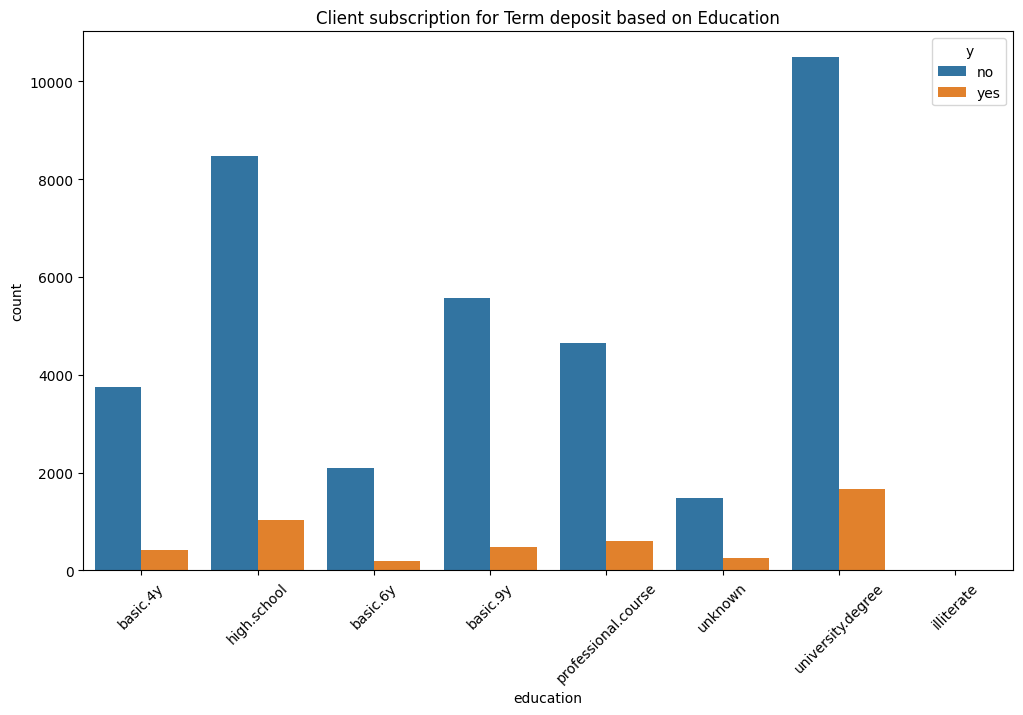

In [11]:
plt.figure(figsize=(12,7))
sns.countplot(raw_df, x="education", hue="y")
plt.xticks(rotation=45)
plt.title("Client subscription for Term deposit based on Education")

_ = g.set(xlabel="Features", ylabel="Count")

The above graph shows that only a small percent of data has unknow values.
Next plot is for month wise distribution of client subscriptions. We see that data is missing for the month og Jan and Feb, we will assume that this means that the campaign period was from March to Dec

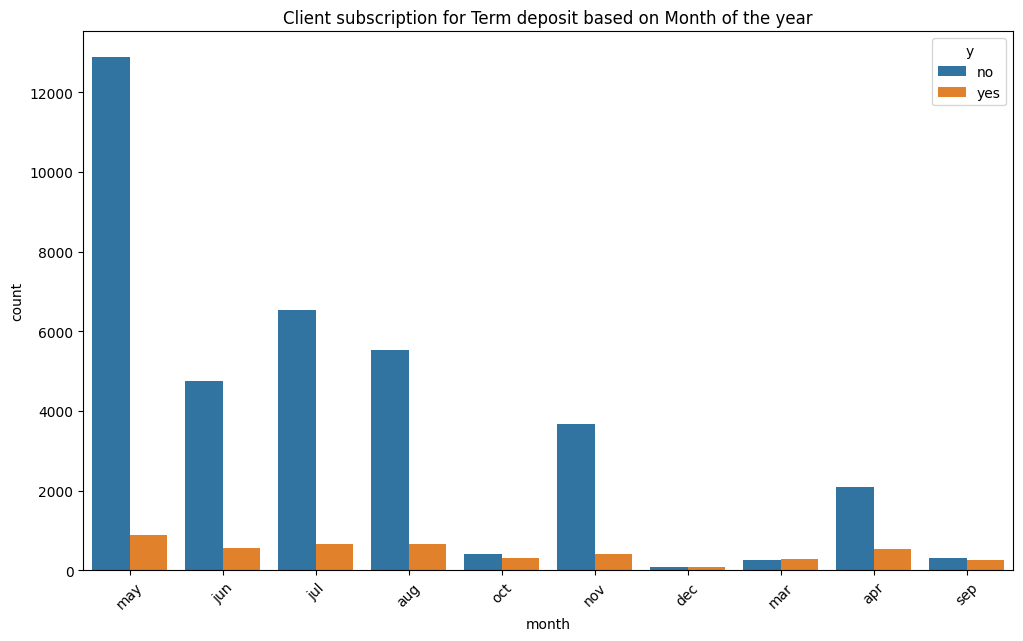

In [12]:
plt.figure(figsize=(12,7))
sns.countplot(raw_df, x="month", hue="y")
plt.xticks(rotation=45)
plt.title("Client subscription for Term deposit based on Month of the year")

_ = g.set(xlabel="Features", ylabel="Count")

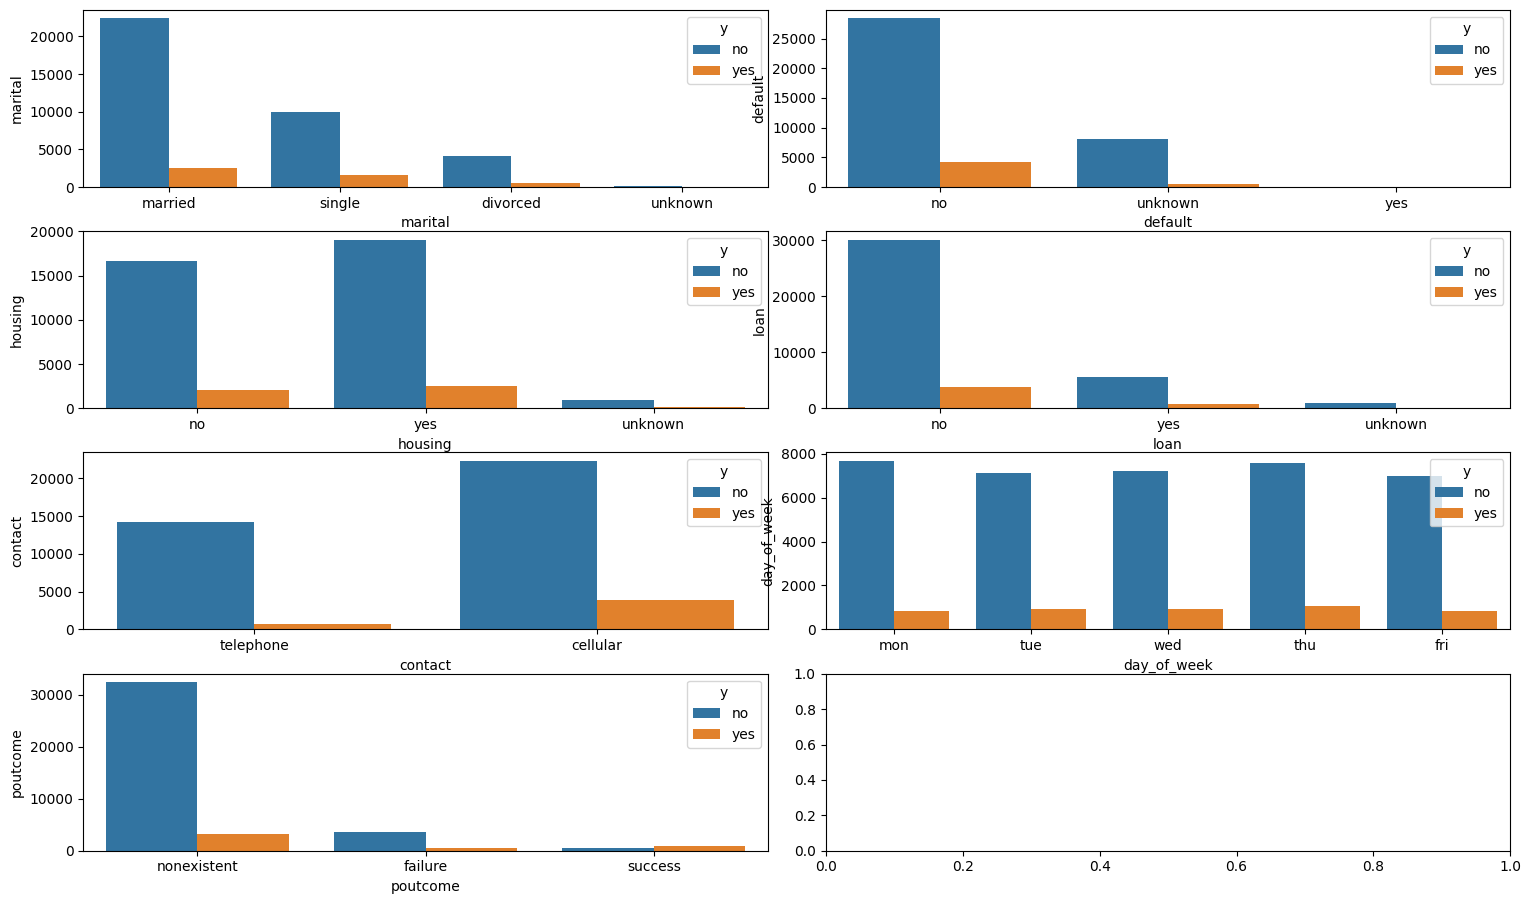

In [13]:

columns_to_plot = ['marital', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome']

fig, axes = plt.subplots(nrows = 4,ncols=2, figsize=(15,9))
fig.tight_layout()
column_index = 0
# Create the boxplot with Seaborn
#print(axes)
for i in range(0,len(columns_to_plot)):
  column = columns_to_plot[int(i)]
  index_x = int(i/2)
  index_y = int(i%2)
  sns.countplot(raw_df, x=column, hue="y",ax=axes[index_x,index_y])
  #axes[index_x,index_y].set_title(column)
  axes[index_x,index_y].set(ylabel=column)

plt.show()

The above graphs show that across most of the columns 'unknown' can be treated as an independent catefory. We will also do feature importance to evaluate if we should try to address the unknown values for **default** feature or not.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The Objective is to use the provided dataset and identify a model and a measure for the qualiuty of the model. The goal for the model is to predict whether a client will subscribe for a term deposit based on various features like age, balance, duration, job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome.

As we already have the prediction for this dataset, we will create different models and use a few different model quality measurement approaches to find the best metric for this problem.





In [14]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  Int64  
 1   job             41188 non-null  string 
 2   marital         41188 non-null  string 
 3   education       41188 non-null  string 
 4   default         41188 non-null  string 
 5   housing         41188 non-null  string 
 6   loan            41188 non-null  string 
 7   contact         41188 non-null  string 
 8   month           41188 non-null  string 
 9   day_of_week     41188 non-null  string 
 10  duration        41188 non-null  Int64  
 11  campaign        41188 non-null  Int64  
 12  pdays           41188 non-null  Int64  
 13  previous        41188 non-null  Int64  
 14  poutcome        41188 non-null  string 
 15  emp.var.rate    41188 non-null  Float64
 16  cons.price.idx  41188 non-null  Float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

Let us create a dataframe for the first 7 columns in the dataset.

In [15]:
first_7features = raw_df[raw_df.columns[0:7]]
first_7features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        41188 non-null  Int64 
 1   job        41188 non-null  string
 2   marital    41188 non-null  string
 3   education  41188 non-null  string
 4   default    41188 non-null  string
 5   housing    41188 non-null  string
 6   loan       41188 non-null  string
dtypes: Int64(1), string(6)
memory usage: 2.2 MB


Create a column transformer for the string columns. We will use a onehot encoder and


In [16]:
ohe_transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary', sparse_output = False), ['job']),
                                           (OneHotEncoder(drop = 'if_binary', sparse_output = False), ['marital']),
                                           (OneHotEncoder(drop = 'if_binary', sparse_output = False), ['education']),
                                           (OneHotEncoder(drop = 'if_binary', sparse_output = False), ['default']),
                                           (OneHotEncoder(drop = 'if_binary', sparse_output = False), ['housing']),
                                           (OneHotEncoder(drop = 'if_binary', sparse_output = False), ['loan']),
                                           (StandardScaler(),['age']),
                                           verbose_feature_names_out=False,
                                          )

In [17]:
y=raw_df['y']

Let us create a few data structures to store the evaluation scores of the different models.



In [18]:
accuracy_scores_test =[]
accuracy_scores_train =[]
model_descs = []
precision_scores_test =[]
precision_scores_train =[]
recall_scores_test =[]
recall_scores_train =[]
roc_auc_scores_test =[]
roc_auc_scores_train =[]
train_fit_times = []


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [19]:

X_train, X_test, y_train, y_test = train_test_split(first_7features, y,
                                                   random_state = 42, test_size=.2)

Let us create a function that will be used to append different scores from multiple strategies.

In [20]:
def append_model_scores(model, model_desc, train_fit_time, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
  y_test_pred = model.predict(X_test)
  y_train_pred = model.predict(X_train)

  model_descs.append(model_desc)
  precision_scores_train.append(precision_score(y_train,y_train_pred,pos_label='yes',zero_division=0))
  precision_scores_test.append(precision_score(y_test,y_test_pred,pos_label='yes',zero_division=0))

  accuracy_scores_train.append(accuracy_score(y_train,y_train_pred))
  accuracy_scores_test.append(accuracy_score(y_test,y_test_pred))

  recall_scores_train.append(recall_score(y_train,y_train_pred,pos_label='yes',zero_division=0))
  recall_scores_test.append(recall_score(y_test,y_test_pred,pos_label='yes',zero_division=0))

  roc_auc_scores_train.append(roc_auc_score(y_train,model.predict_proba(X_train)[:, 1]))
  roc_auc_scores_test.append(roc_auc_score(y_test,model.predict_proba(X_test)[:, 1]))

  train_fit_times.append(train_fit_time)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

To create a simple baseline model let us use DummyClassifier with the strategy of **most_frequent**. This will always predict the most frequent class label.




In [21]:
start_time = datetime.datetime.now()
dummy_clf_pipe = Pipeline([
    ('xform',ohe_transformer),
    ('model',DummyClassifier(strategy='most_frequent'))
])
dummy_clf_pipe.fit(X_train,y_train)


append_model_scores(dummy_clf_pipe, 'DummyClassifier', datetime.datetime.now() - start_time)

print("Accuracy of DummyClassifieron train data: "+str(round(accuracy_scores_train[-1],4) ))
print("Accuracy of DummyClassifier on test data: "+str(round(accuracy_scores_test[-1],4) ))

Accuracy of DummyClassifieron train data: 0.8876
Accuracy of DummyClassifier on test data: 0.8865


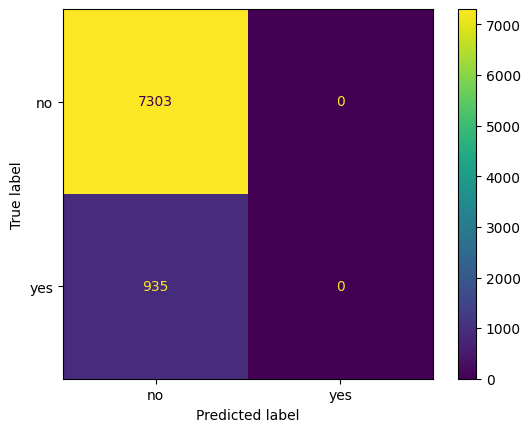

In [22]:
cm = confusion_matrix(y_test, dummy_clf_pipe.predict(X_test), labels=dummy_clf_pipe.named_steps['model'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dummy_clf_pipe.named_steps['model'].classes_)
disp.plot()

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [23]:
start_time = datetime.datetime.now()

lr_pipe = Pipeline([
    ('xform',ohe_transformer),
    ('model',LogisticRegression(max_iter=10000))
])
lr_pipe.fit(X_train,y_train)

append_model_scores(lr_pipe, 'LogisticRegression', datetime.datetime.now() - start_time)


### Problem 9: Score the Model

What is the accuracy of your model?

In [24]:
print("Accuracy of LogisticRegression on train data: "+str(round(accuracy_scores_train[-1],4) ))
print("Accuracy of LogisticRegression on test data: "+str(round(accuracy_scores_test[-1],4) ))

Accuracy of LogisticRegression on train data: 0.8876
Accuracy of LogisticRegression on test data: 0.8865


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### Train a KNN classifier with default settings

In [25]:
start_time = datetime.datetime.now()

knn_pipe = Pipeline([('xform', ohe_transformer),
                      ('model', KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)
append_model_scores(knn_pipe, 'KNN' , datetime.datetime.now() - start_time)


#### Train a Decision Tree with default settings

In [26]:
start_time = datetime.datetime.now()

dtc_pipe = Pipeline([('xform', ohe_transformer),
                      ('model', DecisionTreeClassifier())])
dtc_pipe.fit(X_train, y_train)
append_model_scores(dtc_pipe, 'DecisionTree', datetime.datetime.now() - start_time)

#### Train a SVM with default settings. We have to set the probability to True as for the basic models we are also computing roc_auc_scores. For the next section on improving the model we will only focus on 1 of the scores.

In [27]:
start_time = datetime.datetime.now()

svc_pipe = Pipeline([('xform', ohe_transformer),
                      ('model', SVC(probability = True))])
svc_pipe.fit(X_train, y_train)
append_model_scores(svc_pipe, 'SVC',  datetime.datetime.now() - start_time)

In [28]:
results = {'model':model_descs,'fit time':train_fit_times, 'train accuracy score':accuracy_scores_train,'test accuracy score':accuracy_scores_test,
           'train precision score':precision_scores_train,'test precision score':precision_scores_test,
           'train roc_auc score':precision_scores_train,'test roc_auc score':precision_scores_test}
results_df = pd.DataFrame(results)
results_df = results_df.set_index('model')
results_df.sort_values(by=['test accuracy score'], ascending=False)

,fit time,train accuracy score,test accuracy score,train precision score,test precision score,train roc_auc score,test roc_auc score
model,,,,,,,
SVC,0 days 00:08:39.582031,0.888225,0.886744,0.689655,0.666667,0.689655,0.666667
DummyClassifier,0 days 00:00:00.227924,0.887557,0.886502,0.000000,0.000000,0.000000,0.000000
LogisticRegression,0 days 00:00:01.410714,0.887557,0.886502,0.000000,0.000000,0.000000,0.000000
KNN,0 days 00:00:00.178413,0.890015,0.872663,0.540218,0.252174,0.540218,0.252174
DecisionTree,0 days 00:00:00.212473,0.916601,0.862102,0.922330,0.224658,0.922330,0.224658


Before moving forward, let us look into what measure we will use to measure the quality of the model.

(Taken from Google Search) In general, Categorical prediction model quality measures are used to evaluate how well a model can predict categorical outcomes. There are a number of different metrics that can be used, each with its own strengths and weaknesses.

Accuracy is the most common metric used to evaluate categorical prediction models. It is simply the proportion of predictions that are correct. Accuracy can be a good metric to use if the cost of misclassification is the same for all categories. However, it can be misleading if the cost of misclassification is different for different categories.

Precision is the proportion of positive predictions that are actually correct. Precision can be a good metric to use if the cost of false positives is high. For example, if a model is being used to predict whether or not a patient has a disease, it is important to have a high precision so that patients are not unnecessarily treated for a disease that they do not have.

Recall is the proportion of actual positive cases that are correctly predicted. Recall can be a good metric to use if the cost of false negatives is high. For example, if a model is being used to predict whether or not a customer will churn, it is important to have a high recall so that customers who are likely to churn are not lost.

ROC AUC is the area under the receiver operating characteristic curve. It is a measure of how well a model can distinguish between positive and negative cases. ROC AUC is a good metric to use if the cost of misclassification is different for different categories.

As the cost of misclassification for our dataset doesnt seem to be different we will use accuracy scores for measuring model accurary for the following sections.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

To Identify important features let us first encode all the existing categorical features using OrdinalEncoder.

We will see the correlation between the different features.

Index(['duration', 'nr.employed', 'pdays', 'euribor3m', 'emp.var.rate',
       'poutcome', 'previous', 'month'],
      dtype='object')

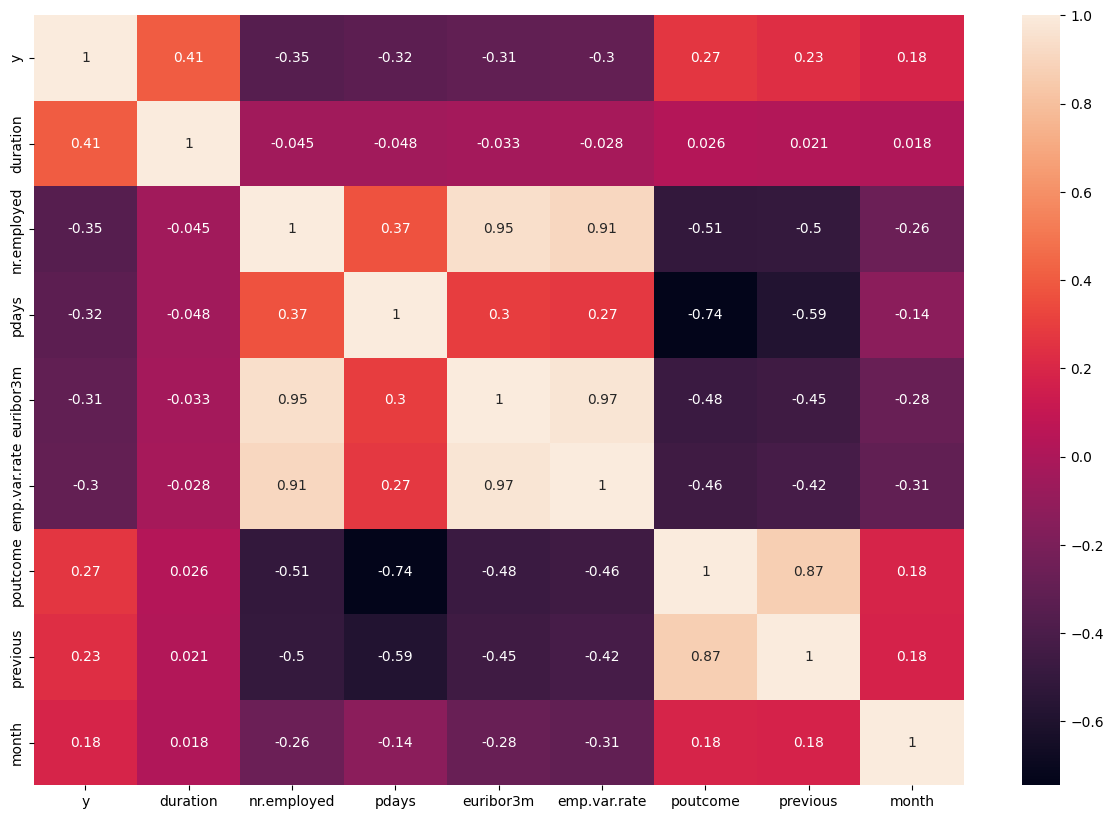

In [29]:

str_cols = raw_df.select_dtypes(include='string').columns.to_list()
oe_encoder = ce.OrdinalEncoder(cols=str_cols)
df3 = oe_encoder.fit_transform(raw_df)
sorted_features = df3.corr()['y'].sort_values(key=abs, ascending=False)

# the first feature is y itself which we will ignore when using the top 8 features.
top_8_features = sorted_features.index[:9]

fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(df3[top_8_features].corr(), annot=True)

top_8_features[1:]

Let us also use SequentialFeatureSelector to select the best 10 features using OrdinalEncoder for String Columns

In [30]:
X = df3.drop('y', axis = 1)
y = df3['y']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 42, test_size=.2)

In [31]:
selector = SequentialFeatureSelector(estimator = LogisticRegression(max_iter=10000), scoring='accuracy', n_features_to_select=8)
Xt = selector.fit_transform(X,y)
sfe_top_features = selector.get_feature_names_out()
sfe_top_features

array(['age', 'marital', 'education', 'loan', 'day_of_week', 'duration',
       'pdays', 'poutcome'], dtype=object)

Features identified as important by both correlation and SequentialFeatureSelector

In [32]:
list(set(top_8_features) & set(sfe_top_features))

['poutcome', 'pdays', 'duration']

Let us create a Logistic regression model with all the features and compute the accuracy score of the resulting model.

We will compare the accuracy scores across different models considering all and top 8 features.

In [33]:
X = raw_df.drop('y', axis = 1)
y = raw_df['y']

X_select = raw_df[sfe_top_features]

X_train, X_test, X_select_train, X_select_test, y_train, y_test = train_test_split(X, X_select, y,
                                                   random_state = 42, test_size=.2)

accuracy_scores_train2 =[]
accuracy_scores_test2 =[]
model_descs2 = []
train_fit_times2 = []
best_estimator=[]
def append_model_accuracy_score(model, model_desc, train_fit_time,X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
  # fit the model for all features first followed by top 8 features
  y_test_pred = model.predict(X_test)
  y_train_pred = model.predict(X_train)

  model_descs2.append(model_desc)

  accuracy_scores_train2.append(accuracy_score(y_train,y_train_pred))
  accuracy_scores_test2.append(accuracy_score(y_test,y_test_pred))
  train_fit_times2.append(train_fit_time)
  best_estimator.append(model)


### Model analysis for all features

In [34]:
ohe2_encoder = make_column_transformer((OneHotEncoder(drop = 'if_binary', sparse_output = False), X_train.select_dtypes(include='string').columns),
                                       remainder=StandardScaler(),
                                       verbose_feature_names_out=False,
                                      )

In [35]:
start_time = datetime.datetime.now()
lr_pipe2 = Pipeline([
    ('xform',ohe2_encoder),
    ('model',LogisticRegression(max_iter=10000))
])
lr_pipe2.fit(X_train,y_train)
fit_time = datetime.datetime.now() - start_time
append_model_accuracy_score(lr_pipe2, 'LogisticRegression - ALL', fit_time.seconds)

print("Accuracy of LogisticRegression on train data: "+str(round(accuracy_scores_train2[-1],4) ))
print("Accuracy of LogisticRegression on test data: "+str(round(accuracy_scores_test2[-1],4) ))


Accuracy of LogisticRegression on train data: 0.9118
Accuracy of LogisticRegression on test data: 0.9114


We will now use GridSearch to find the best model for LogisticRegression

In [36]:
params = {
          'model__solver':['lbfgs','liblinear'],
          'model__max_iter':list(range(1000, 10000, 500))
          }

lr_pipe = Pipeline([
    ('xform',ohe2_encoder),
    ('model',LogisticRegression())
])
grid_cv = GridSearchCV(estimator=lr_pipe,param_grid=params,cv=5)
grid_cv.fit(X_train,y_train)

append_model_accuracy_score(grid_cv.best_estimator_, 'LogisticRegression - Grid CV - ALL', np.mean(grid_cv.cv_results_['mean_fit_time']))


We will now use GridSearch to find the best model for KNeighborsClassifier

In [37]:
params = {
          'model__n_neighbors':list(range(1, 10, 1))
          }

knn_pipe = Pipeline([('xform', ohe2_encoder),
                      ('model', KNeighborsClassifier())])

grid_cv_knn = GridSearchCV(estimator=knn_pipe,param_grid=params,cv=5)
grid_cv_knn.fit(X_train,y_train)
append_model_accuracy_score(grid_cv_knn.best_estimator_, 'KNN - Grid CV - ALL', np.mean(grid_cv_knn.cv_results_['mean_fit_time']))


We will now use GridSearch to find the best model for SVC

In [38]:
params = {'model__kernel': ['linear','poly','rbf']}
svc_pipe = Pipeline([('xform', ohe2_encoder),
                      ('model', SVC())])
grid_cv_scv = GridSearchCV(estimator=svc_pipe,param_grid=params,cv=5)
grid_cv_scv.fit(X_train,y_train)
append_model_accuracy_score(grid_cv_scv.best_estimator_, 'SVC - Grid CV - ALL', np.mean(grid_cv_scv.cv_results_['mean_fit_time']))


We will now use GridSearch to find the best model for DecisionTreeClassifier

In [39]:
params = {'model__min_impurity_decrease': [0.01, 0.02],
         'model__max_depth': [2, 5, 10],
         'model__min_samples_split': [0.1, 0.2]}

clf_pipe = Pipeline([('xform', ohe2_encoder),
                      ('model', DecisionTreeClassifier(random_state = 42))])
grid = GridSearchCV(clf_pipe,params)
grid.fit(X_train, y_train)
append_model_accuracy_score(grid.best_estimator_, 'DecisionTree - Grid CV - ALL', np.mean(grid.cv_results_['mean_fit_time']))


In [40]:
results = {'model':model_descs2,'train score':accuracy_scores_train2,'test score':accuracy_scores_test2,'average fit time':train_fit_times2}
results_df = pd.DataFrame(results)
results_df = results_df.set_index('model')

results_df.sort_values(by='test score', ascending=False)

,train score,test score,average fit time
model,,,
SVC - Grid CV - ALL,0.922701,0.911629,17.778045
LogisticRegression - ALL,0.911775,0.911386,2.000000
LogisticRegression - Grid CV - ALL,0.911775,0.911386,0.766439
KNN - Grid CV - ALL,0.919514,0.902646,0.125869
DecisionTree - Grid CV - ALL,0.904127,0.901068,0.231922


### Model Analysis for top 8 features

In [41]:
ohe3_encoder = make_column_transformer((OneHotEncoder(drop = 'if_binary', sparse_output = False), X_select_train.select_dtypes(include='string').columns),
                                       remainder=StandardScaler(),
                                       verbose_feature_names_out=False,
                                      )

In [42]:
start_time = datetime.datetime.now()
lr_pipe2 = Pipeline([
    ('xform',ohe3_encoder),
    ('model',LogisticRegression(max_iter=10000))
])
lr_pipe2.fit(X_select_train,y_train)
fit_time = datetime.datetime.now() - start_time
append_model_accuracy_score(lr_pipe2, 'LogisticRegression - Top8', fit_time.seconds, X_select_train, X_select_test)

print("Accuracy of LogisticRegression - Top8 on train data: "+str(round(accuracy_scores_train2[-1],4) ))
print("Accuracy of LogisticRegression - Top8 on test data: "+str(round(accuracy_scores_test2[-1],4) ))


Accuracy of LogisticRegression - Top8 on train data: 0.9047
Accuracy of LogisticRegression - Top8 on test data: 0.9059


We will now use GridSearch to find the best model for LogisticRegression

In [43]:
params = {
          'model__solver':['lbfgs','liblinear'],
          'model__max_iter':list(range(1000, 10000, 500))
          }

lr_pipe = Pipeline([
    ('xform',ohe3_encoder),
    ('model',LogisticRegression())
])
grid_cv = GridSearchCV(estimator=lr_pipe,param_grid=params,cv=5)
grid_cv.fit(X_select_train,y_train)

append_model_accuracy_score(grid_cv.best_estimator_, 'LogisticRegression - Grid CV - Top8', np.mean(grid_cv.cv_results_['mean_fit_time']), X_select_train, X_select_test)


We will now use GridSearch to find the best model for KNeighborsClassifier

In [44]:
params = {
          'model__n_neighbors':list(range(1, 10, 1))
          }

knn_pipe = Pipeline([('xform', ohe3_encoder),
                      ('model', KNeighborsClassifier())])

grid_cv_knn = GridSearchCV(estimator=knn_pipe,param_grid=params,cv=5)
grid_cv_knn.fit(X_select_train,y_train)
append_model_accuracy_score(grid_cv_knn.best_estimator_, 'KNN - Grid CV - Top8', np.mean(grid_cv_knn.cv_results_['mean_fit_time']), X_select_train, X_select_test)


We will now use GridSearch to find the best model for SVC

In [45]:
params = {'model__kernel': ['linear','poly','rbf']}
svc_pipe = Pipeline([('xform', ohe3_encoder),
                      ('model', SVC())])
grid_cv_scv = GridSearchCV(estimator=svc_pipe,param_grid=params,cv=5)
grid_cv_scv.fit(X_select_train,y_train)
append_model_accuracy_score(grid_cv_scv.best_estimator_, 'SVC - Grid CV - Top8', np.mean(grid_cv_scv.cv_results_['mean_fit_time']), X_select_train, X_select_test)


We will now use GridSearch to find the best model for DecisionTreeClassifier

In [46]:
params = {'model__min_impurity_decrease': [0.01, 0.02],
         'model__max_depth': [2, 5, 10],
         'model__min_samples_split': [0.1, 0.2]}

clf_pipe = Pipeline([('xform', ohe3_encoder),
                      ('model', DecisionTreeClassifier(random_state = 42))])
grid = GridSearchCV(clf_pipe,params)
grid.fit(X_select_train, y_train)
append_model_accuracy_score(grid.best_estimator_, 'DecisionTree - Grid CV - Top8', np.mean(grid.cv_results_['mean_fit_time']), X_select_train, X_select_test)


In [47]:
results = {'model':model_descs2,'train score':accuracy_scores_train2,'test score':accuracy_scores_test2,'average fit time':train_fit_times2}
results_df = pd.DataFrame(results)
#results_df = results_df.set_index('model')

results_df[results_df['model'].str.contains('Top8')].sort_values(by='test score', ascending=False)

,model,train score,test score,average fit time
8,SVC - Grid CV - Top8,0.909287,0.906288,37.864738
5,LogisticRegression - Top8,0.904674,0.905924,0.000000
6,LogisticRegression - Grid CV - Top8,0.904674,0.905924,0.357773
7,KNN - Grid CV - Top8,0.913141,0.899005,0.095104
9,DecisionTree - Grid CV - Top8,0.894871,0.891600,0.114004


Comparing the accuracy score between the different models for all features vis a vis top 8 features we observe that

- Order of best accuracy scores follows the order SVC(best) > LogisticRegression > KNN > DecisionTree(lowest).

- Model fit times also increase DecisionTree(least) < KNN < LogisticRegression < SVC(Maximum)

Let us also look at what are the parameters choosen for the best estimators for the Grid Search for the same model with different parameters

In [48]:
pd.set_option('display.max_colwidth', None)
best_models = {'model':model_descs2,'best estimator':best_estimator,'test score':accuracy_scores_test2}
models_df = pd.DataFrame(best_models)
models_df.sort_values(by='model')

,model,best estimator,test score
4,DecisionTree - Grid CV - ALL,"(ColumnTransformer(remainder=StandardScaler(),\n transformers=[('onehotencoder',\n OneHotEncoder(drop='if_binary',\n sparse_output=False),\n Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',\n 'month', 'day_of_week', 'poutcome'],\n dtype='object'))],\n verbose_feature_names_out=False), DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.01,\n min_samples_split=0.1, random_state=42))",0.901068
9,DecisionTree - Grid CV - Top8,"(ColumnTransformer(remainder=StandardScaler(),\n transformers=[('onehotencoder',\n OneHotEncoder(drop='if_binary',\n sparse_output=False),\n Index(['marital', 'education', 'loan', 'day_of_week', 'poutcome'], dtype='object'))],\n verbose_feature_names_out=False), DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.01,\n min_samples_split=0.1, random_state=42))",0.891600
2,KNN - Grid CV - ALL,"(ColumnTransformer(remainder=StandardScaler(),\n transformers=[('onehotencoder',\n OneHotEncoder(drop='if_binary',\n sparse_output=False),\n Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',\n 'month', 'day_of_week', 'poutcome'],\n dtype='object'))],\n verbose_feature_names_out=False), KNeighborsClassifier(n_neighbors=9))",0.902646
7,KNN - Grid CV - Top8,"(ColumnTransformer(remainder=StandardScaler(),\n transformers=[('onehotencoder',\n OneHotEncoder(drop='if_binary',\n sparse_output=False),\n Index(['marital', 'education', 'loan', 'day_of_week', 'poutcome'], dtype='object'))],\n verbose_feature_names_out=False), KNeighborsClassifier(n_neighbors=9))",0.899005
0,LogisticRegression - ALL,"(ColumnTransformer(remainder=StandardScaler(),\n transformers=[('onehotencoder',\n OneHotEncoder(drop='if_binary',\n sparse_output=False),\n Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',\n 'month', 'day_of_week', 'poutcome'],\n dtype='object'))],\n verbose_feature_names_out=False), LogisticRegression(max_iter=10000))",0.911386
1,LogisticRegression - Grid CV - ALL,"(ColumnTransformer(remainder=StandardScaler(),\n transformers=[('onehotencoder',\n OneHotEncoder(drop='if_binary',\n sparse_output=False),\n Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',\n 'month', 'day_of_week', 'poutcome'],\n dtype='object'))],\n verbose_feature_names_out=False), LogisticRegression(max_iter=1000))",0.911386
6,LogisticRegression - Grid CV - Top8,"(ColumnTransformer(remainder=StandardScaler(),\n transformers=[('onehotencoder',\n OneHotEncoder(drop='if_binary',\n sparse_output=False),\n Index(['marital', 'education', 'loan', 'day_of_week', 'poutcome'], dtype='object'))],\n verbose_feature_names_out=False), LogisticRegression(max_iter=1000))",0.905924
5,LogisticRegression - Top8,"(ColumnTransformer(remainder=StandardScaler(),\n transformers=[('onehotencoder',\n OneHotEncoder(drop='if_binary',\n sparse_output=False),\n Index(['marital', 'education', 'loan', 'day_of_week', 'poutcome'], dtype='object'))],\n verbose_feature_names_out=False), LogisticRegression(max_iter=10000))",0.905924
3,SVC - Grid CV - ALL,"(ColumnTransformer(remainder=StandardScaler(),\n transformers=[('onehotencoder',\n OneHotEncoder(drop='if_binary',\n sparse_output=False),\n Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',\n 'month', 'day_of_week', 'poutcome'],\n dtype='object'))],\n verbose_feature_names_out=False), SVC())",0.911629
8,SVC - Grid CV - Top8,"(ColumnTransformer(remainder=StandardScaler(),\n transformers=[('onehotencoder',\n OneHotEncoder(drop='if_binary',\n sparse_output=False),\n Index(['marital', 'education', 'loan', 'day_of_week', 'poutcome'], dtype='object'))],\n verbose_feature_names_out=False), SVC())",0.906288


The above analyisis hihlights an important aspect that using Grid Search for the same model architecture but different features selected same hyperparameters but the test scores did differ with models trained on all features having higher accuracy score then models trained on top 8 features.

In [49]:
models_df[['model','test score']].sort_values(by='test score', ascending=False)

,model,test score
3,SVC - Grid CV - ALL,0.911629
0,LogisticRegression - ALL,0.911386
1,LogisticRegression - Grid CV - ALL,0.911386
8,SVC - Grid CV - Top8,0.906288
5,LogisticRegression - Top8,0.905924
6,LogisticRegression - Grid CV - Top8,0.905924
2,KNN - Grid CV - ALL,0.902646
4,DecisionTree - Grid CV - ALL,0.901068
7,KNN - Grid CV - Top8,0.899005
9,DecisionTree - Grid CV - Top8,0.891600


### Compare feature importance across the top 8 feature models

Feature importance from Logistic Regression Model

In [50]:
r = permutation_importance(grid_cv, X_select_test, y_test, n_repeats=30,random_state=42, scoring='accuracy')

df = pd.DataFrame({'Feature': X_select_test.columns,
                              'Importance': r.importances_mean})

df.sort_values(by='Importance', ascending=False, inplace=True)
ttl = "Feature Importance using LogisticRegression"
print(ttl)
df

Feature Importance using LogisticRegression


,Feature,Importance
5,duration,0.035021
6,pdays,0.011933
7,poutcome,0.007376
1,marital,0.001044
3,loan,0.000113
2,education,0.000093
0,age,-0.000142
4,day_of_week,-0.000166


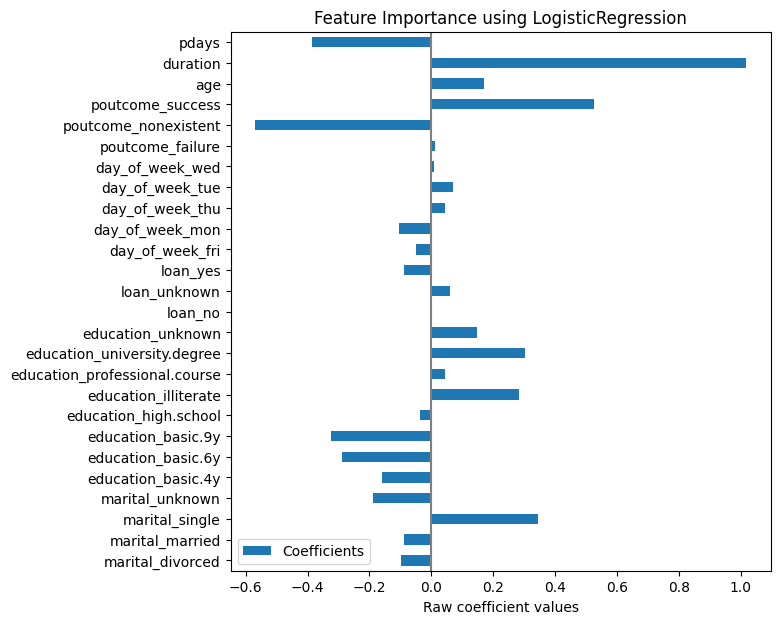

In [51]:
coefs = pd.DataFrame(
    grid_cv.best_estimator_.named_steps['model'].coef_[0],
    columns=["Coefficients"],
    index=grid_cv.best_estimator_.named_steps['xform'].get_feature_names_out(),
)

coefs.plot.barh(figsize=(9, 7))
plt.title(ttl)
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

Looking at the feature importance for the above model we can see that relative order of feature importance as

duration >	pdays > poutcome > marital >	loan >	education	>	age	>	day_of_week

However when we look at the different sub categories across each of the features the relative importance is

- poutcome_success - implying customer who had prevously participated in a campaign are more likely to participate again.
- marital_single - implying married people are more likely to participate in a campaign.
- education_university.degree/education_illiterate  - implying people with degree or no education are more likely to participate in a campaign.
- day_of_week_tue/day_of_week_thu - customers are more likely to participate in a campaign on a Tuesday or Thursday.



Let us also Visualize feature importance based on coefficients for Logistic regression model with all features.


In [52]:
r = permutation_importance(best_estimator[1], X_test, y_test, n_repeats=30,random_state=42, scoring='accuracy')

df = pd.DataFrame({'Feature': X_test.columns,
                              'Importance': r.importances_mean})

df.sort_values(by='Importance', ascending=False, inplace=True)
ttl = "Feature Importance using LogisticRegression with all features"
print(ttl)
df

Feature Importance using LogisticRegression with all features


,Feature,Importance
15,emp.var.rate,0.179085
10,duration,0.039136
16,cons.price.idx,0.034899
18,euribor3m,0.013685
12,pdays,0.004916
8,month,0.004512
7,contact,0.001845
19,nr.employed,0.001376
14,poutcome,0.001137
4,default,0.001040


In [53]:
pd.set_option('display.max_rows', None)
coefs.sort_values(by='Coefficients', ascending=False, inplace=True)
coefs

,Coefficients
duration,1.017897
poutcome_success,0.525343
marital_single,0.344571
education_university.degree,0.303351
education_illiterate,0.282724
age,0.171045
education_unknown,0.146538
day_of_week_tue,0.068861
loan_unknown,0.059309
education_professional.course,0.044551


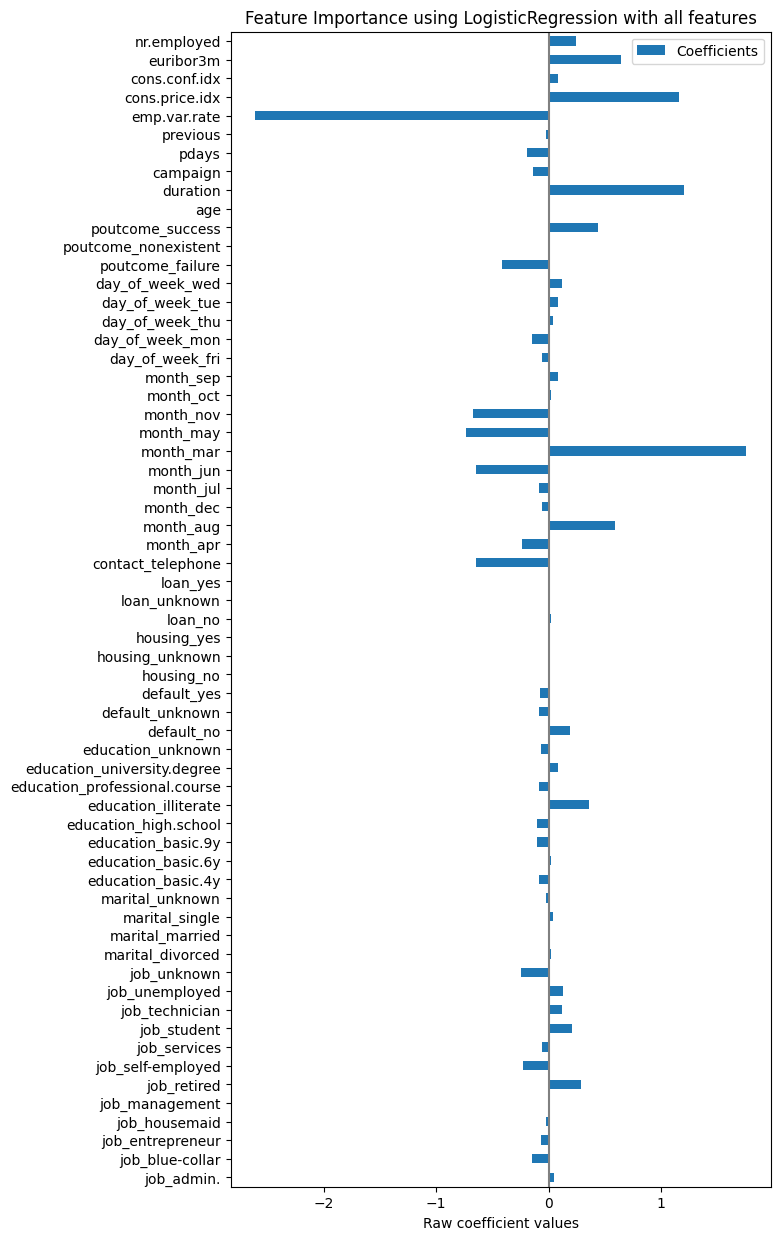

In [54]:
coefs = pd.DataFrame(
    best_estimator[1].named_steps['model'].coef_[0],
    columns=["Coefficients"],
    index=best_estimator[1].named_steps['xform'].get_feature_names_out(),
)

coefs.plot.barh(figsize=(9, 15))
plt.title(ttl)
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

Looking at the feature importance for the above model we can see that relative order of feature importance as  

emp.var.rate	>	duration	>	cons.price.idx	>	euribor3m	>	pdays	>	month	>	contact	>	nr.employed	>	poutcome	>	default	>	job

However when we look at the different sub categories across each of the features the relative importance is

- Among months March and Aug had higher succesful campaigns.
- for poutcome, success category had a higher coefficient implying customer who had prevously participated in a campaign are more likely to participate again.
- for education, illiterate category had a higher coefficient implying people with no education are more likely to participate in a campaign.
- for job, category retired had higher coefficient followed by student
- for default, no defaults had highe coefficient
- for day_of_week, campaign coefficients for wed was highest followed by tue.
- for marital, single category had highest coefficients
- for loan, no personal loan had higher coefficients than other categories.

### Summary

- Technical Analysis
 - We analysed different features and types of models(LogisticRegression, KNeighborsClassifier, SVC, DecisionTreeClassifier) to predict if a customer will subscribe for term deposit by analyzing a dataset of 41187 rows and 19 features.

 - We explored different metrics(accuracy_score,roc_auc_score, precision_score, recall_score) for evaluation of these models.

  - SVC outperformed other models over the choosen metric(accuracy) with score > .90 on both test an train dataset.

  - Accuracy score differed by ~1% between SVC model with all features vs top 8 features. Hence if we have to opt for a less complex model with potentialy low computation latency an 8 feature model can perform almost as good as a model with all features.

  - Hyperparameters for the same model across different split of features were same.


- Business Analysis
 - Using a subset of 8 features ('age', 'marital', 'education', 'loan', 'day_of_week', 'duration', 'pdays', 'poutcome') we are able to accurately predict in 91% of the cases that a client will subscribe for term deposit.
 - Using all the features a client subscription accuracy score was 91.1%.
 - Among different categories of features clients are more likely to accept a compaign if
   1.   During the months of March and Aug.
   2.   If they had prevously participated in a campaign.
   3.   If the education level is low.
   4.   If the job category was retired or they were a student.
   5.   They had not defaulted earlier.
   6.   If the call for the campaign was made on Wednessday followed by Tuesday.
   7.   If the marital status was single.
   8.   If the client hadnt taken a personal loan.



Disclaimer:- These observations are derived from a small dataset of ~42K clients. The dataset is missing various geographical and locality specific economic features that might have influenced any subset of users towards a choice for accepting a term deposit. Hence any generalization of this analysis should be used if the factors in that economy are similar to the clients used for this analysis.